# Project 1

# Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

# Desarrollo de modelo para predicción de precios de autos

Para el desarrollo de la predicción de precios de autos se probaron dos tipos de modelos ensamblados, boosting y random forest.

Dado el tamaño de la muestra se redujo la base de datos a 20.000 registros, lo que generó parámetros óptimos para la estimación de los modelos.

In [13]:
##Parameters
size_sample=20000
estimator_range = range(300, 1000, 50)
max_depth_range = range(10, 50, 5)
feature_range = range(2, 13, 1)

Las librerías utilizadas para la estimación de los modelos fueron las siguientes.

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
import category_encoders as ce
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [15]:
data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')

In [16]:
data.shape

(500000, 6)

In [5]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

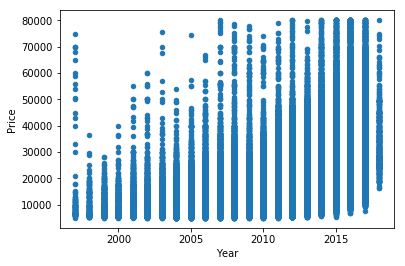

In [6]:
data.plot(kind='scatter', y='Price', x='Year')

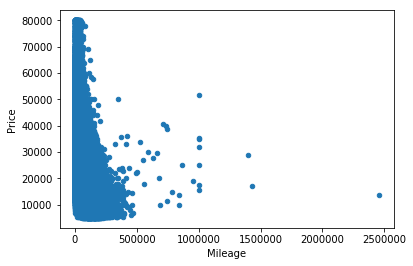

In [7]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [17]:
data.State = data.State.str.lstrip()
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


Teniendo en cuenta las características de los datos se decidió crear un índice ponderado de precio interestatal, que permite identificar si los precios por modelos en cada Estado se encuentran por encima o por deajo del promedio nacional. 

**Nota:** Este índice se desarrollo en Tableau y se exportó a un CSV para ser utilizado tanto en el entrenamiento del modelo, como en el web service.

La variable **Year** se modificó para que sea la diferencia entre 2019 y el año de referencia del carro; así que en estos momentos esta variable nos explica cuantos años de antigüedad tiene el carro al día de hoy.

In [18]:
def createFeatures(data):
    data.State = data.State.str.lstrip()
    data = data.reset_index()
    stateRate = pd.read_csv("StatesRate.csv")
    data = data.set_index('State').join(stateRate.set_index('State')).reset_index()
    data.Year = 2019-data.Year
    data["MakeModel4"] = data["Make"] + data["Model"].str[:4]
    data=data.drop(['State'], axis=1)
    return data

In [19]:
stateRate = pd.read_csv("StatesRate.csv")
stateRate.head()

,State,RateState
0,FL,0.962969
1,MI,0.965131
2,OH,0.968848
3,OK,0.973919
4,GA,0.974889


In [20]:
data = createFeatures(data).set_index("index")
data.head()

,Price,Year,Mileage,Make,Model,RateState,MakeModel4
index,,,,,,,
757,6700,7,107728,Nissan,Sentra4dr,1.042688,NissanSent
1174,14625,7,94715,Subaru,Outback2.5i,1.042688,SubaruOutb
1495,17194,5,32977,Buick,RegalPremium,1.042688,BuickRega
1521,9995,8,94837,Buick,Regal4dr,1.042688,BuickRega
2194,9194,10,66501,Toyota,Corolla4dr,1.042688,ToyotaCoro


Las variables categóricas fueron transformadas con el codificador binario; el archivo **BinEncoder.pkl** fue utilizado para estimar las predicciones del modelo y para el correcto funcionamiento del web service.

In [21]:
#Create the binary encoder and save it
BinEncoder = ce.BinaryEncoder().fit(data.drop(['Price'], axis=1))
joblib.dump(BinEncoder, 'BinEncoder.pkl', compress=3)
print("Origninal Data: ", data.shape)

#Create sample that it will be use for find the hiperparameters, after select features X and Y
data_sample = data.sample(n=size_sample, random_state=1)
Y = data_sample.Price
X = BinEncoder.transform(data_sample.drop(['Price'], axis=1))
print("Y sample: ", Y.shape)
print("X sample: ", X.shape)
X.head()

Origninal Data:  (500000, 7)
Y sample:  (20000,)
X sample:  (20000, 30)


,Make_0,Make_1,Make_2,Make_3,Make_4,Make_5,Make_6,Model_0,Model_1,Model_2,...,MakeModel4_2,MakeModel4_3,MakeModel4_4,MakeModel4_5,MakeModel4_6,MakeModel4_7,MakeModel4_8,Year,Mileage,RateState
index,,,,,,,,,,,,,,,,,,,,,
28961,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,10,57407,1.080224
205531,0,0,0,1,0,0,0,0,0,1,...,1,0,0,1,1,1,0,2,10421,0.994189
308395,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,8,60726,0.978508
117495,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,1,1,1,3,41495,0.994189
308461,0,0,0,0,1,1,0,0,0,0,...,0,1,1,1,1,0,1,3,13504,0.978508


In [22]:
# Split the data that is going to be use to find the random forest parameters
size = 0.3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,test_size=size).copy()

Se dividieron los datos en **Train (0.7)** y **Test (0,3)** para encontrar los hiper parámetros adecuados para el modelo.

# Finding max parameters

### Finding max estimators

best_n_estimator:  950


Text(0, 0.5, 'NEG_RMSE')

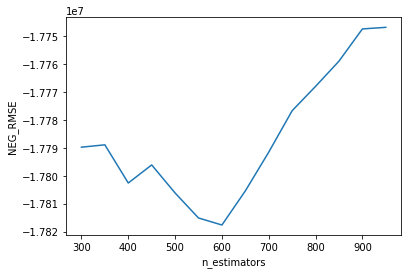

In [18]:
#list of values to try for n_estimators
RMSE_scores_estim = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rf  = RandomForestRegressor (n_estimators=estimator,max_features=8, max_depth=15, random_state=1, n_jobs=-1)
    RMSE_scores_estim.append(cross_val_score(rf, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean())

best_n_estimator = estimator_range[RMSE_scores_estim.index(max(RMSE_scores_estim))]
print ("best_n_estimator: ", best_n_estimator)
plt.plot(estimator_range, RMSE_scores_estim)
plt.xlabel('n_estimators')
plt.ylabel('NEG_RMSE')

### Finding max depth

best_depth:  15


Text(0, 0.5, 'RMSE')

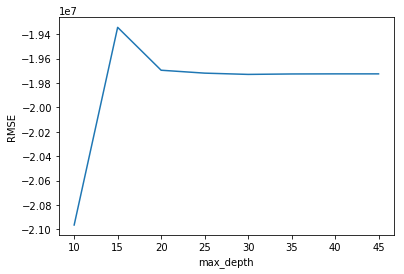

In [23]:
#list of values to try for n_estimators
RMSE_scores_depth = []
# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for depth in max_depth_range:
    rf  = RandomForestRegressor (n_estimators=400, max_depth=depth, random_state=1, n_jobs=-1)
    RMSE_scores_depth.append(cross_val_score(rf, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean())

best_depth = max_depth_range[RMSE_scores_depth.index(max(RMSE_scores_depth))]
print ("best_depth: ", best_depth)
plt.plot(max_depth_range, RMSE_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

### Finding max features

best_maxfeatures:  4


Text(0, 0.5, 'NEG_RMSE')

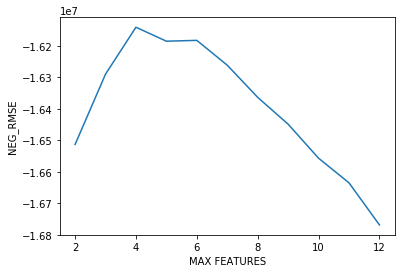

In [19]:
# list of values to try for max_features

RMSE_scores_featu = []
# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rf  = RandomForestRegressor(n_estimators=500, max_features=feature, max_depth=15, random_state=1, n_jobs=-1)
    RMSE_scores_featu.append(cross_val_score(rf, X, Y, cv=5, scoring='neg_mean_squared_error').mean())

best_maxfeatures = feature_range[RMSE_scores_featu.index(max(RMSE_scores_featu))]
print ("best_maxfeatures: ", best_maxfeatures)
plt.plot(feature_range, RMSE_scores_featu)
plt.xlabel('MAX FEATURES')
plt.ylabel('NEG_RMSE')

# Train the model

In [9]:
#Create de features
Y = data.Price
X = BinEncoder.transform(data.drop(['Price'], axis=1))
print("Y: ", Y.shape)
print("X: ", X.shape)

#Train the model selecting the best found parameters
size = 0.3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,test_size=size).copy()
print ("Rows train: ", len(X_train))
X_train.head()

Y:  (500000,)
X:  (500000, 30)
Rows train:  350000


,Make_0,Make_1,Make_2,Make_3,Make_4,Make_5,Make_6,Model_0,Model_1,Model_2,...,MakeModel4_2,MakeModel4_3,MakeModel4_4,MakeModel4_5,MakeModel4_6,MakeModel4_7,MakeModel4_8,Year,Mileage,RateState
index,,,,,,,,,,,,,,,,,,,,,
377727,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,1,1,7,57432,0.999828
212934,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,4,59909,0.974889
341392,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,1,1,0,5,26535,1.080224
269561,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2,29053,0.974889
396570,0,0,1,1,0,0,0,0,0,0,...,1,0,0,1,1,0,0,7,85056,1.007226


Se estiman un RandomForest con los hiper parámetros encontrados y se hacen las predicciones correspondientes.

In [10]:
rf = RandomForestRegressor(n_estimators=950, max_depth=15, max_features=8, random_state=1, n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [11]:
y_pred_train = rf.predict(X_validation)
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_validation, y_pred_train)))

RMSE: 3473.774499301229


# Train the model with all data

Se estima un modelo con toda la base de datos y se hacen las predicciones del caso.

In [17]:
rf.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [20]:
data_test = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTest_carListings.zip', index_col=0)

In [21]:
data_test = createFeatures(data_test).set_index('ID')
data_test.head()

,Year,Mileage,Make,Model,RateState,MakeModel4
ID,,,,,,
134,16,189346,Toyota,Tundra4WD,1.042688,ToyotaTund
1108,2,2186,Chevrolet,TraverseAWD,1.042688,ChevroletTrav
1418,7,62756,Ford,Fusion4dr,1.042688,FordFusi
2311,4,30595,Nissan,Pathfinder4WD,1.042688,NissanPath
2432,4,16094,Chevrolet,Silverado,1.042688,ChevroletSilv


In [22]:
#Codify the test dataset with "BinEncoder"
X_test = BinEncoder.transform(data_test)
print("X_test: ", X_test.shape)

X_test:  (250000, 30)


## Predict the price for the test dataset

In [23]:
y_pred = pd.DataFrame(rf.predict(X_test),index=data_test.index,columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')
print("The data was exported to CSV file call test_submission.csv")

The data was exported to CSV file call test_submission.csv


In [18]:
joblib.dump(rf, 'RF_modelcars.pkl', compress=3)

['RF_modelcars.pkl']

Se estima un modelo tipo boosting, pero no resulta mejor que el Random Forest.

from sklearn.ensemble import GradientBoostingRegressor
clfgrad = GradientBoostingRegressor(n_estimators=400, max_depth=15, max_features=8, random_state=1)
clfgrad.fit(X_train, Y_train)

y_pred_clfgrad = clfgrad.predict(X_validation)
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_validation, y_pred_clfgrad)))

clfAda = AdaBoostRegressor(RandomForestRegressor(n_estimators=800, max_depth=15, max_features=8, random_state=1, n_jobs=-1), n_estimators=10)
clfAda.fit(X_train, Y_train)

y_pred_clfAda = clfAda.predict(X_validation)
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_validation, y_pred_clfAda)))

# Exercise P1.2 (50%)

Create an API of the model.

![](https://github.com/gomezivan/Uniandes/blob/master/Screenshot%20WebService.png)

https://github.com/gomezivan/Uniandes/blob/master/Screenshot%20WebService.png

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine]
